In [8]:
from pathlib import Path
from typing import Tuple, List
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

import matplotlib.pyplot as plt



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\RoooC\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\RoooC\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\RoooC\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Users\RoooC\anaconda3\Lib\site-pack

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [3]:
HERE = Path.cwd()

PROJECT_ROOT = HERE.parents[1]
DATA_RAW = PROJECT_ROOT / "data_files"
DATA_PROC = HERE / "processed_data"
MASTER_PATH = DATA_PROC / "melt_panel_master.csv"

# Load data + NA check

In [4]:
RANDOM_STATE = 42

def prepare_df(
    master_path: Path = MASTER_PATH,
    pos_quantile: float = 0.75,
) -> Tuple[pd.DataFrame, float]:
    """
    1. Drop melt rate NaN rows -> Main Target
    2. Set y_high_melt=0.75
    3. NANs double check: dorpna
    """
    df = pd.read_csv(master_path)
    df = df.dropna(subset=["melt_rate"])

    threshold = df["melt_rate"].quantile(pos_quantile)
    df["y_high_melt"] = (df["melt_rate"] >= threshold).astype(int)

    print(f"High-melt threshold at quantile {pos_quantile:.2f}: {threshold:.3f}")
    print("Overall class balance:")
    print(df["y_high_melt"].value_counts(normalize=True))

    target_col = "y_high_melt"
    drop_cols = [
        target_col,
        "melt_rate",
        "melt_count",
        "n_app",
        "n_admit",
        "n_enroll",
        "cc_name",
        "uc_campus",
    ]
    feature_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feature_cols]

    mask = df["year"].notna()
    nan_row_mask = X.isna().any(axis=1)

    n_total = X[mask].shape[0]
    n_nan_rows = (mask & nan_row_mask).sum()
    n_after = (mask & ~nan_row_mask).sum()

    print("\n===== Missing summary (feature space, all years) =====")
    print(f"Total rows (year not NA): {n_total}")
    print(f"Rows with >=1 NaN in features: {n_nan_rows}")
    print(f"Rows remaining after dropna(): {n_after}")

    df_clean = df.loc[mask & ~nan_row_mask].copy()
    print(f"Rows kept for modeling after missing handling: {df_clean.shape[0]}")

    return df_clean, threshold

# Model session

## Split

In [5]:
def make_splits(
    df: pd.DataFrame,
    train_end_year: int = 2018,
    main_test_year: int = 2019,
    covid_start_year: int = 2020,
):
    """
    - Train: year <= train_end_year
    - Main test: year == main_test_year
    - COVID/post-COVID: year >= covid_start_year
    """
    target_col = "y_high_melt"
    drop_cols = [
        target_col,
        "melt_rate",
        "melt_count",
        "n_app",
        "n_admit",
        "n_enroll",
    ]

    feature_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feature_cols]
    y = df[target_col]

    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    years = df["year"]

    train_mask = years <= train_end_year
    main_test_mask = years == main_test_year
    covid_mask = years >= covid_start_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_test_main, y_test_main = X[main_test_mask], y[main_test_mask]
    X_test_covid, y_test_covid = X[covid_mask], y[covid_mask]

    print("\n=== Split summary (after missing handling up front) ===")
    print("Train years:", sorted(df.loc[train_mask, "year"].unique()))
    print("Main test years:", sorted(df.loc[main_test_mask, "year"].unique()))
    print("COVID/post-COVID years:", sorted(df.loc[covid_mask, "year"].unique()))
    print(
        "Train size:", X_train.shape,
        " Main test size:", X_test_main.shape,
        " COVID size:", X_test_covid.shape,
    )

    return (
        X_train,
        y_train,
        X_test_main,
        y_test_main,
        X_test_covid,
        y_test_covid,
        numeric_cols,
        categorical_cols,
    )


def build_preprocessor(
    numeric_cols: List[str],
    categorical_cols: List[str],
) -> ColumnTransformer:
    """
    ColumnTransformer：
    - Numeric：StandardScaler
    - Categorical：OneHotEncoder
    """
    numeric_transformer = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ]
    )
    return preprocessor



def get_splits_and_preprocessor():
    """
    One-stop helper for training scripts.

    Returns:
    - X_train, y_train
    - X_test_main, y_test_main
    - X_test_covid, y_test_covid
    - preprocessor
    """
    df, threshold = prepare_df()

    (
        X_train,
        y_train,
        X_test_main,
        y_test_main,
        X_test_covid,
        y_test_covid,
        numeric_cols,
        categorical_cols,
    ) = make_splits(df)

    preprocessor = build_preprocessor(numeric_cols, categorical_cols)

    return (
        X_train,
        y_train,
        X_test_main,
        y_test_main,
        X_test_covid,
        y_test_covid,
        preprocessor,
        threshold,
    )


## Model func

In [6]:
def fit_glm(X_train, y_train, preprocessor):
    """
    GLM L2+balanced
    """
    base_model = LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=5000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", base_model),
        ]
    )

    param_grid = {
        "model__C": [0.01, 0.1, 1.0, 10.0]
                }

    clf = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
    )

    clf.fit(X_train, y_train)
    print("\n[GLM] Best params:", clf.best_params_)
    print("[GLM] Best CV AUC:", clf.best_score_)

    return clf.best_estimator_

In [7]:
def fit_rf(X_train, y_train, preprocessor):
    """
    Random Forest
    """
    base_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", base_model),
        ]
    )

    param_grid = {
        "model__max_depth": [5, 10, None],
        "model__min_samples_leaf": [5, 10, 20],
    }

    clf = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
    )

    clf.fit(X_train, y_train)
    print("\n[RF] Best params:", clf.best_params_)
    print("[RF] Best CV AUC:", clf.best_score_)

    return clf.best_estimator_

In [8]:
def evaluate_model(model, X, y, label="dataset"):
    """
    Print AUC, PR-AUC, confusion matrix, and classification report.
    """
    if X.shape[0] == 0:
        print(f"\n==== {label}: empty, skipped ====")
        return

    proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    auc = roc_auc_score(y, proba)
    ap = average_precision_score(y, proba)
    print(f"\n==== Performance on {label} ====")
    print(f"AUC:     {auc:.3f}")
    print(f"PR-AUC:  {ap:.3f}")
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print("Classification report:\n", classification_report(y, pred))


## Main

In [9]:
(
    X_train,
    y_train,
    X_test,
    y_test,
    X_covid,
    y_covid,
    preprocessor,
    threshold,
) = get_splits_and_preprocessor()

print(f"\nUsing high-melt threshold (quantile): {threshold:.3f}")


High-melt threshold at quantile 0.75: 0.864
Overall class balance:
y_high_melt
0    0.749688
1    0.250312
Name: proportion, dtype: float64

===== Missing summary (feature space, all years) =====
Total rows (year not NA): 17654
Rows with >=1 NaN in features: 267
Rows remaining after dropna(): 17387
Rows kept for modeling after missing handling: 17387

=== Split summary (after missing handling up front) ===
Train years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Main test years: [2019]
COVID/post-COVID years: [2020, 2021, 2022, 2023, 2024]
Train size: (11692, 22)  Main test size: (917, 22)  COVID size: (4778, 22)

Using high-melt threshold (quantile): 0.864


In [10]:
glm_model = fit_glm(X_train, y_train, preprocessor)
evaluate_model(glm_model, X_test, y_test, label="L1: Main test (2019)")
evaluate_model(glm_model, X_covid, y_covid, label="L1: COVID/post-COVID (>=2020)")

Fitting 5 folds for each of 4 candidates, totalling 20 fits

[GLM] Best params: {'model__C': 0.1}
[GLM] Best CV AUC: 0.8876815445680135

==== Performance on L1: Main test (2019) ====
AUC:     0.913
PR-AUC:  0.767
Confusion matrix:
 [[622 106]
 [ 38 151]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.90       728
           1       0.59      0.80      0.68       189

    accuracy                           0.84       917
   macro avg       0.76      0.83      0.79       917
weighted avg       0.87      0.84      0.85       917


==== Performance on L1: COVID/post-COVID (>=2020) ====
AUC:     0.901
PR-AUC:  0.778
Confusion matrix:
 [[2982  522]
 [ 286  988]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      3504
           1       0.65      0.78      0.71      1274

    accuracy                           0.83      4778
   macro avg       0

In [11]:
rf_model = fit_rf(X_train, y_train, preprocessor)
evaluate_model(rf_model, X_test, y_test, label="Main test (2019)")
evaluate_model(rf_model, X_covid, y_covid, label="COVID/post-COVID (>=2020)")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

[RF] Best params: {'model__max_depth': None, 'model__min_samples_leaf': 5}
[RF] Best CV AUC: 0.8947948499335237

==== Performance on Main test (2019) ====
AUC:     0.924
PR-AUC:  0.771
Confusion matrix:
 [[651  77]
 [ 46 143]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       728
           1       0.65      0.76      0.70       189

    accuracy                           0.87       917
   macro avg       0.79      0.83      0.81       917
weighted avg       0.88      0.87      0.87       917


==== Performance on COVID/post-COVID (>=2020) ====
AUC:     0.904
PR-AUC:  0.785
Confusion matrix:
 [[3215  289]
 [ 441  833]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3504
           1       0.74      0.65      0.70      1274

    accuracy                           0.85  

In [ ]:
results_main = X_test.copy()
results_main["y_true"] = y_test.values
results_main["glm_proba"] = glm_model.predict_proba(X_test)[:, 1]
results_main["rf_proba"] = rf_model.predict_proba(X_test)[:, 1]
results_main.to_csv(
    DATA_PROC / "results" / "melt_model_main_test_predictions.csv",
    index=False,
)

results_covid = X_covid.copy()
results_covid["y_true"] = y_covid.values
if X_covid.shape[0] > 0:
    results_covid["glm_proba"] = glm_model.predict_proba(X_covid)[:, 1]
    results_covid["rf_proba"] = rf_model.predict_proba(X_covid)[:, 1]
results_covid.to_csv(
    DATA_PROC / "results" /"melt_model_covid_predictions.csv",
    index=False,
)

print("Saved")

Saved


# Visuals + Interpretation

In [ ]:
PRED_FILES: List[Path] = [
    DATA_PROC / "results" / "melt_model_main_test_predictions.csv",
    DATA_PROC / "results" / "melt_model_covid_predictions.csv",
]

PROBA_COL = "glm_proba"

HIGH_RISK_THRESHOLD = 0.6

## Heatmap

In [2]:
dfs = []
for path in PRED_FILES:
    df = pd.read_csv(path)
    dfs.append(df)

pred = pd.concat(dfs, ignore_index=True)

df = pred.copy()
df["high_pred_flag"] = (df[PROBA_COL] >= HIGH_RISK_THRESHOLD).astype(int)

agg_dict = dict(
    true_high_share=("y_true", "mean"),
    mean_proba=(PROBA_COL, "mean"),
    high_pred_share=("high_pred_flag", "mean"),
    n_obs=("year", "count"),
    n_years=("year", "nunique"),
)

comp_cols = [
     'cc_ug_enroll_12m', 'cc_coa_ay',
       'uc_ug_enroll_12m', 'uc_coa_ay', 'share_gender_female',
       'share_gender_male', 'share_eth_african_american',
       'share_eth_american_indian', 'share_eth_asian',
       'share_eth_hispanic__latinx', "share_eth_int'l",
       'share_eth_pacific_islander', 'share_eth_white', 'cc_uc_drive_hours',
       'cc_aid_promise_amt', 'cc_aid_grants_amt', 'cc_aid_loans_amt',
       'cc_aid_scholarship_amt', 'cc_perm_resident_share'

]

for c in comp_cols:
    if c in df.columns:
        agg_dict[c] = (c, "mean")
pair_summary = (
    df.groupby(["cc_name", "uc_campus"], as_index=False)
      .agg(**agg_dict)
      .sort_values(
          by=["true_high_share", "mean_proba"],
          ascending=[False, False],
      )
)

heat = pair_summary.pivot(
    index="cc_name",
    columns="uc_campus",
    values="mean_proba",
)

row_order = heat.mean(axis=1).sort_values(ascending=True).index
heat = heat.loc[row_order]

data = heat.to_numpy()

fig, ax = plt.subplots(figsize=(4.5, 6.5))
im = ax.imshow(
    data,
    aspect="auto",
    origin="lower",
    cmap="Blues",
    vmin=0.0,
    vmax=1.0,
)

uc_names = heat.columns.to_list()
ax.set_xticks(np.arange(len(uc_names)))
ax.set_xticklabels(uc_names, rotation=45, ha="right", fontsize=8)

ax.set_yticks([])
ax.set_ylabel("")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("mean_proba")

heatmap_out = DATA_PROC / "plots" / "melt_cc_uc_heatmap.png"
heatmap_out.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(heatmap_out, dpi=300)
print("Saved:", heatmap_out)


NameError: name 'PRED_FILES' is not defined

## ROC

In [1]:
# ---- inputs ----
df = pred.copy()

# filter to 2020 (adjust if your column is string vs int)
df = df.loc[df["year"].astype(int) == 2020].copy()

# keep only needed columns and drop missing
df = df.dropna(subset=["y_true", "glm_proba", "rf_proba"]).copy()

y = df["y_true"].astype(int).values
p_glm = df["glm_proba"].values
p_rf  = df["rf_proba"].values

out_prefix = Path(DATA_PROC) / "plots" / "glm_rf_main2020"
out_prefix.parent.mkdir(parents=True, exist_ok=True)

# ---- ROC ----
fpr_glm, tpr_glm, _ = roc_curve(y, p_glm)
fpr_rf,  tpr_rf,  _ = roc_curve(y, p_rf)

fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
ax_roc.plot(fpr_glm, tpr_glm, label="GLM")
ax_roc.plot(fpr_rf, tpr_rf, label="RF")
ax_roc.plot([0, 1], [0, 1], "--", color="grey")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("Main 2020 ROC")
ax_roc.legend()
fig_roc.tight_layout()

out_roc = out_prefix.with_name(out_prefix.name + "_roc.png")
fig_roc.savefig(out_roc, dpi=300)
plt.close(fig_roc)

# ---- PR ----
prec_glm, rec_glm, _ = precision_recall_curve(y, p_glm)
prec_rf,  rec_rf,  _ = precision_recall_curve(y, p_rf)

fig_pr, ax_pr = plt.subplots(figsize=(5, 4))
ax_pr.plot(rec_glm, prec_glm, label="GLM")
ax_pr.plot(rec_rf,  prec_rf,  label="RF")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Main 2020 PR curve")
ax_pr.legend()
fig_pr.tight_layout()

out_pr = out_prefix.with_name(out_prefix.name + "_pr.png")
fig_pr.savefig(out_pr, dpi=300)
plt.close(fig_pr)

print(f"Saved:\n- {out_roc}\n- {out_pr}")


NameError: name 'pred' is not defined

Saved


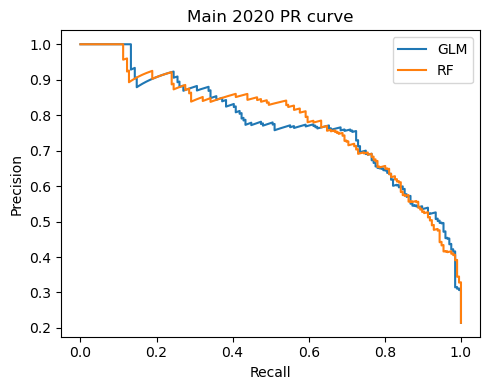

In [18]:
save_roc_pr_curves(pred,year_cond=(pred["year"] == 2020),)

## Driving distance

In [39]:
def save_all_distance_bins(
    pred: pd.DataFrame,
    value_col: str = "glm_proba",
    out_path: Path = DATA_PROC / "cc_uc_drive_hours.png",
):
    df = pred.dropna(subset=["cc_uc_drive_hours", value_col]).copy()

    bins = [0, 0.5, 1.5, 2.5, 3.5,4.5]
    labels = ["<0.5", "1.5–2.5", "2.5–3.5", "3.5-4.5",">4.5"]
    df["dist_bin"] = pd.cut(df["cc_uc_drive_hours"], bins=bins, labels=labels, right=False)

    g = (
        df.groupby("dist_bin", as_index=False)
          .agg(
              risk=(value_col, "mean"),
              n_obs=("y_true", "size"),
          )
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(g["dist_bin"], g["risk"])
    ax.set_xlabel("CC–UC distance (hours)")
    ax.set_ylabel("Predicted risk (mean proba)")
    ax.set_title("Predicted melt risk by hours bin (all campuses)")
    fig.tight_layout()

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300)
    print("Saved:", out_path)


C:\Users\RoooC\AppData\Local\Temp\ipykernel_16052\2266252095.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("dist_bin", as_index=False)


Saved: c:\Users\RoooC\Documents\GitHub\ucd-sta-221-project\ucd_sta_221_project\ml\q3_enrollment_melt\processed_data\cc_uc_drive_hours.png


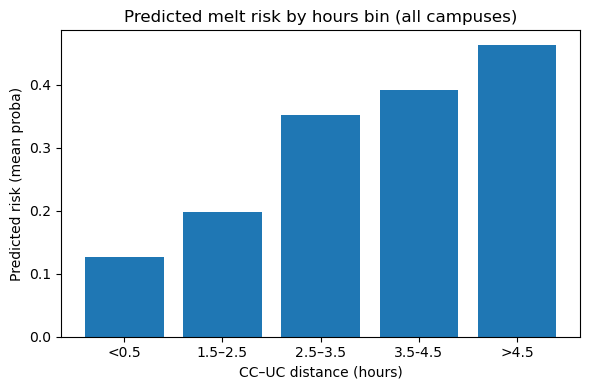

In [40]:
save_all_distance_bins(pred)


## GLM permutation importance

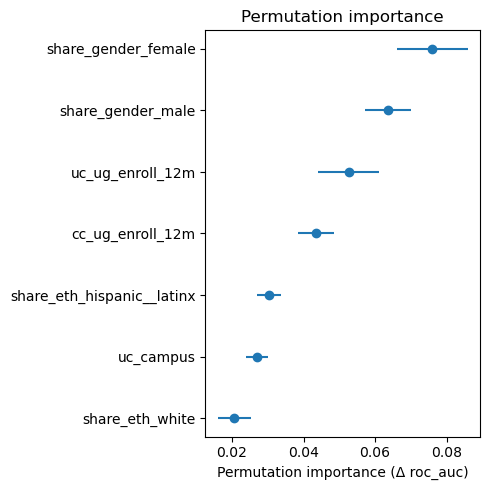

In [112]:
r = permutation_importance(
    glm_model, X_test, np.ravel(y_test),
    scoring="roc_auc",
    n_repeats=10,
    random_state=0,
    n_jobs=1
)

imp = (pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
})
.sort_values("importance_mean", ascending=False)
.head(7))

imp_plot = imp.iloc[::-1]
y_pos = np.arange(len(imp_plot))

plt.figure(figsize=(5, 5))
plt.errorbar(imp_plot["importance_mean"], y_pos, xerr=imp_plot["importance_std"], fmt="o")
plt.yticks(y_pos, imp_plot["feature"])
plt.xlabel("Permutation importance (Δ roc_auc)")
plt.title("Permutation importance")
plt.tight_layout()
plt.savefig(DATA_PROC / "melt_permutation.png", dpi=300, bbox_inches="tight")
plt.show()

## Visual: Not included in the report.

In [ ]:
def save_uc_trend(
    pred: pd.DataFrame,
    uc_name: str,
    proba_col: str = "glm_proba",
    out_dir: Path = DATA_PROC,  
):

    df = pred.loc[pred["uc_campus"] == uc_name].copy()

    year_summary = (
        df.groupby("year", as_index=False)
          .agg(
              true_high_share=("y_true", "mean"),
              mean_proba=(proba_col, "mean"),
          )
          .sort_values("year")
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(year_summary["year"], year_summary["true_high_share"],
            marker="o", label="Observed high-melt share")
    ax.plot(year_summary["year"], year_summary["mean_proba"],
            marker="o", label="Predicted risk")

    ax.axvline(2020, linestyle="--", color="grey", label="COVID onset")

    ax.set_xlabel("Year")
    ax.set_ylabel("Share / probability")
    ax.set_title(f"{uc_name}: high-melt trend over time")
    ax.legend()
    fig.tight_layout()

    out_path = out_dir / f"uc_trend_glm_{uc_name}.png"

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300)

    print("Saved:", out_path)

In [ ]:
save_uc_trend(
    pred,
    uc_name="Merced",
)

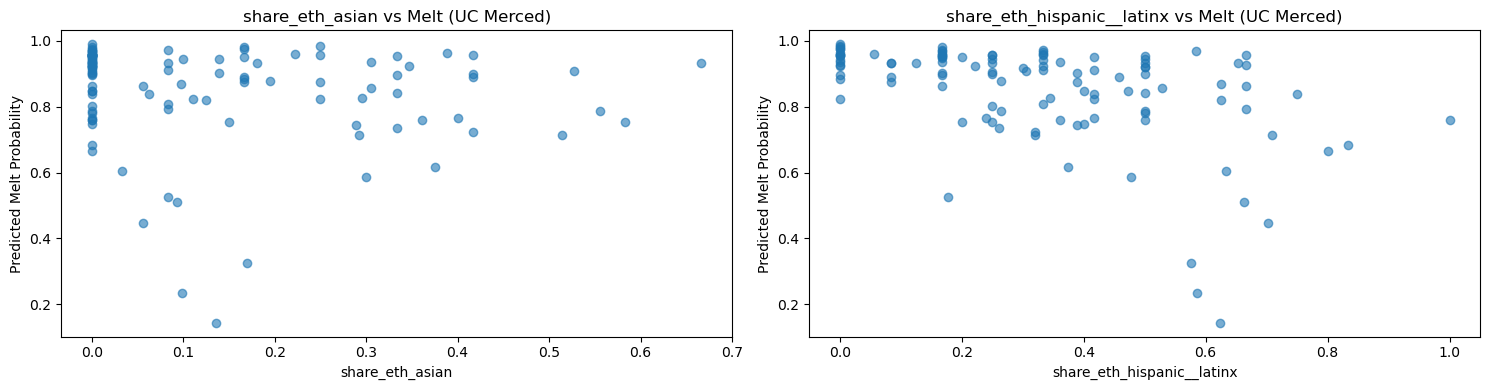

In [62]:
ucm_pairs = pair_summary[pair_summary['uc_campus'] == 'Merced'].copy()
ucm_pairs['melt_zscore'] = (
    (ucm_pairs['mean_proba'] - ucm_pairs['mean_proba'].mean()) 
    / ucm_pairs['mean_proba'].std()
)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot 1: share_eth_asian
axes[0].scatter(ucm_pairs['share_eth_asian'], ucm_pairs['mean_proba'], alpha=0.6)
axes[0].set_xlabel('share_eth_asian')
axes[0].set_ylabel('Predicted Melt Probability')
axes[0].set_title('share_eth_asian vs Melt (UC Merced)')

# Plot 2: share_eth_hispanic__latinx
axes[1].scatter(ucm_pairs['share_eth_hispanic__latinx'], ucm_pairs['mean_proba'], alpha=0.6)
axes[1].set_xlabel('share_eth_hispanic__latinx')
axes[1].set_ylabel('Predicted Melt Probability')
axes[1].set_title('share_eth_hispanic__latinx vs Melt (UC Merced)')

plt.tight_layout()
plt.savefig(DATA_PROC / "ucm_melt_UCM_eth.png", dpi=300)
plt.show()

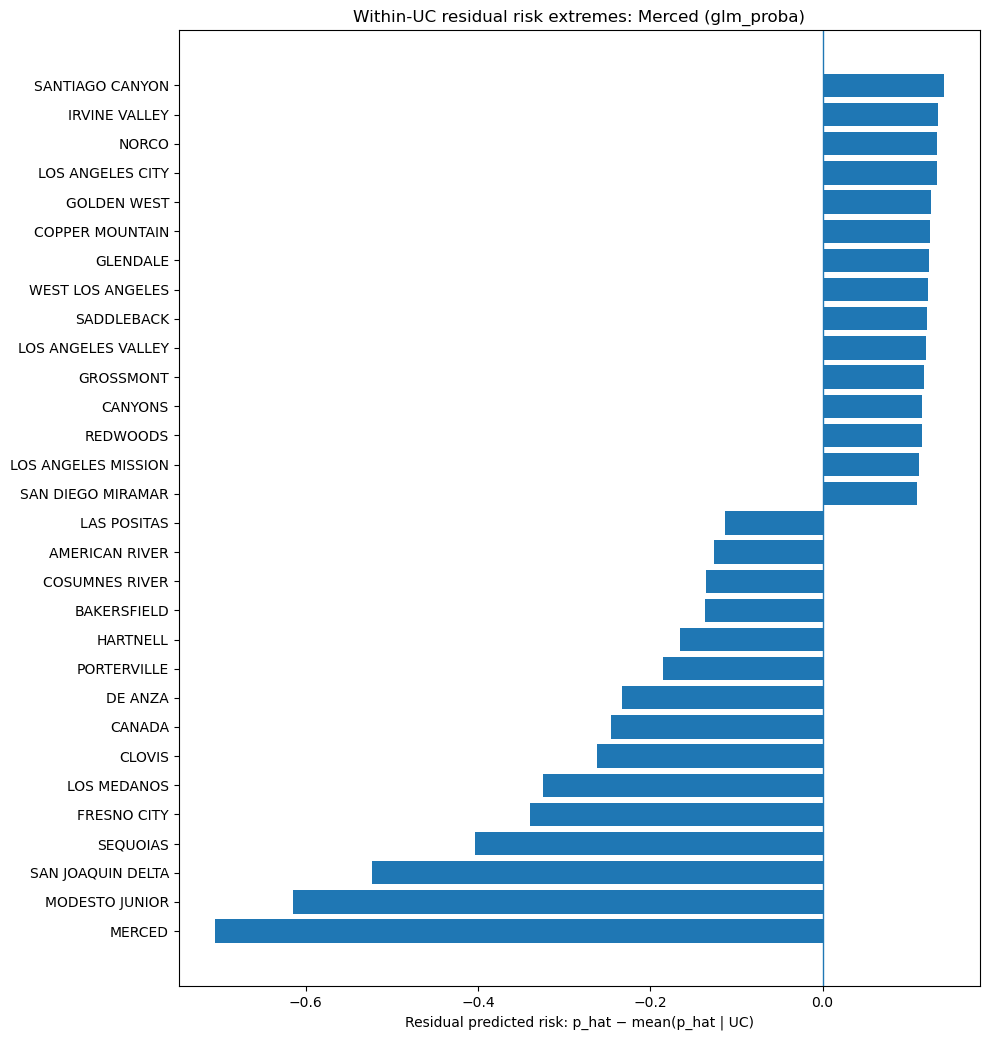

In [120]:
tmp = pred.copy()
tmp["uc_mean_proba"] = tmp.groupby("uc_campus")[PROBA_COL].transform("mean")
tmp["resid_within_uc"] = tmp[PROBA_COL] - tmp["uc_mean_proba"]

sub = tmp[tmp["uc_campus"] == "Merced"].copy()
s = sub.groupby("cc_name")["resid_within_uc"].mean().sort_values(ascending=False)

top = s.head(15)
bot = s.tail(15)
plot_s = pd.concat([bot, top]).sort_values()

y = np.arange(len(plot_s))
plt.figure(figsize=(10, max(5, 0.35 * len(plot_s))))
plt.axvline(0.0, linewidth=1)
plt.barh(y, plot_s.values)
plt.yticks(y, plot_s.index)
plt.xlabel("Residual predicted risk: p_hat − mean(p_hat | UC)")
plt.title(f"Within-UC residual risk extremes: {"Merced"} ({PROBA_COL})")

plt.tight_layout()
plt.savefig(DATA_PROC / "Within_UCM_residual_risk.png", dpi=300)
plt.show()